# Reforestation planning problem

In this example, we will address a reforestation planning problem ...

First lets import the necessary libraries:

In [43]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib import colors
from rasterio import features
from shapely.geometry import shape, Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal import weights
import networkx as nx

Then, lets load our forest cover map, and plot it:

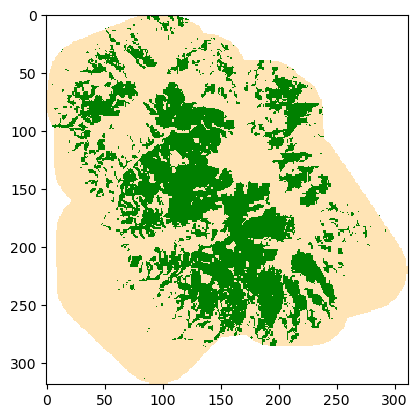

<AxesSubplot:>

In [44]:
forest_kaala = rasterio.open("./data/forest_kaala.tif")
transform = forest_kaala.transform
pixel_size = forest_kaala.res
forest_kaala = forest_kaala.read()
cmap = colors.ListedColormap(["moccasin", "green"])
show(forest_kaala, cmap=cmap)

In this map, pixels with value 1 correspond to forested areas, and pixels with value 0 correspond to non-forested areas that are in within the boundaries of the study area. Pixels with value NaN are out of the study area. From this map we will extract to maps:

   1. The forest area within the study area.
   2. The non-forest areas within the study area.

<AxesSubplot:>

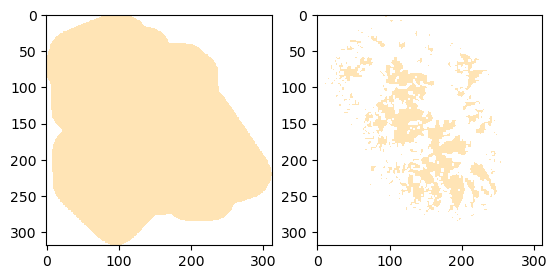

In [45]:
study_area = forest_kaala.copy()
study_area[study_area >= 0] = 0
forest = forest_kaala.copy()
forest[forest != 1] =  None

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)

show(study_area, cmap=cmap, ax=ax1)
show(forest, cmap=cmap, ax=ax2)

Now, we convert both of these maps to vector data. The vector data will contain one attribute, `type`, which we set to 1 for forest areas, and to 0 for non-forest areas.

<AxesSubplot:>

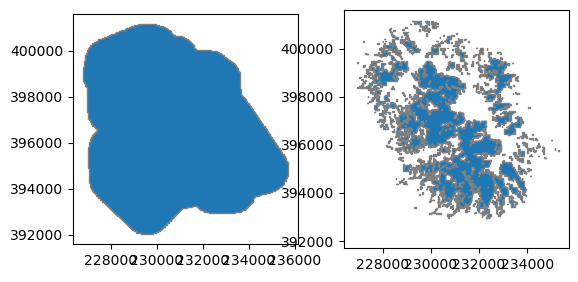

In [46]:
# Vectorize forest patches
forest_shapes = features.shapes(forest, transform=transform)
geometry = []
for shapedict, value in forest_shapes:
    if value == 1:
        geometry.append(shape(shapedict))
forest_vector = gpd.GeoDataFrame(
    {'type': 1, 'geometry': geometry},
    crs="EPSG:3163"
)

# Vectorize non forest areas
non_forest_shape = features.shapes(study_area, transform=transform)
geometry = []
for shapedict, value in non_forest_shape:
    if value == 0:
        geometry.append(shape(shapedict))

# build the gdf object over the two lists
study_area_vector = gpd.GeoDataFrame(
    {'type': 0, 'geometry': geometry },
    crs="EPSG:3163"
)

# Plot the result
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
study_area_vector.plot(edgecolor="grey", ax=ax1)
forest_vector.plot(edgecolor="grey", ax=ax2)

Now, we need to tessellate the non-forest area in order to define our planning units. Let's do it with squared planning units of width 500 m.

Now, we need to determine the adjacency between planning units and existing forest patches. To do so, we merge our two vector layers, and use libpysal to construct a spatial graph representing these adjacency relations.

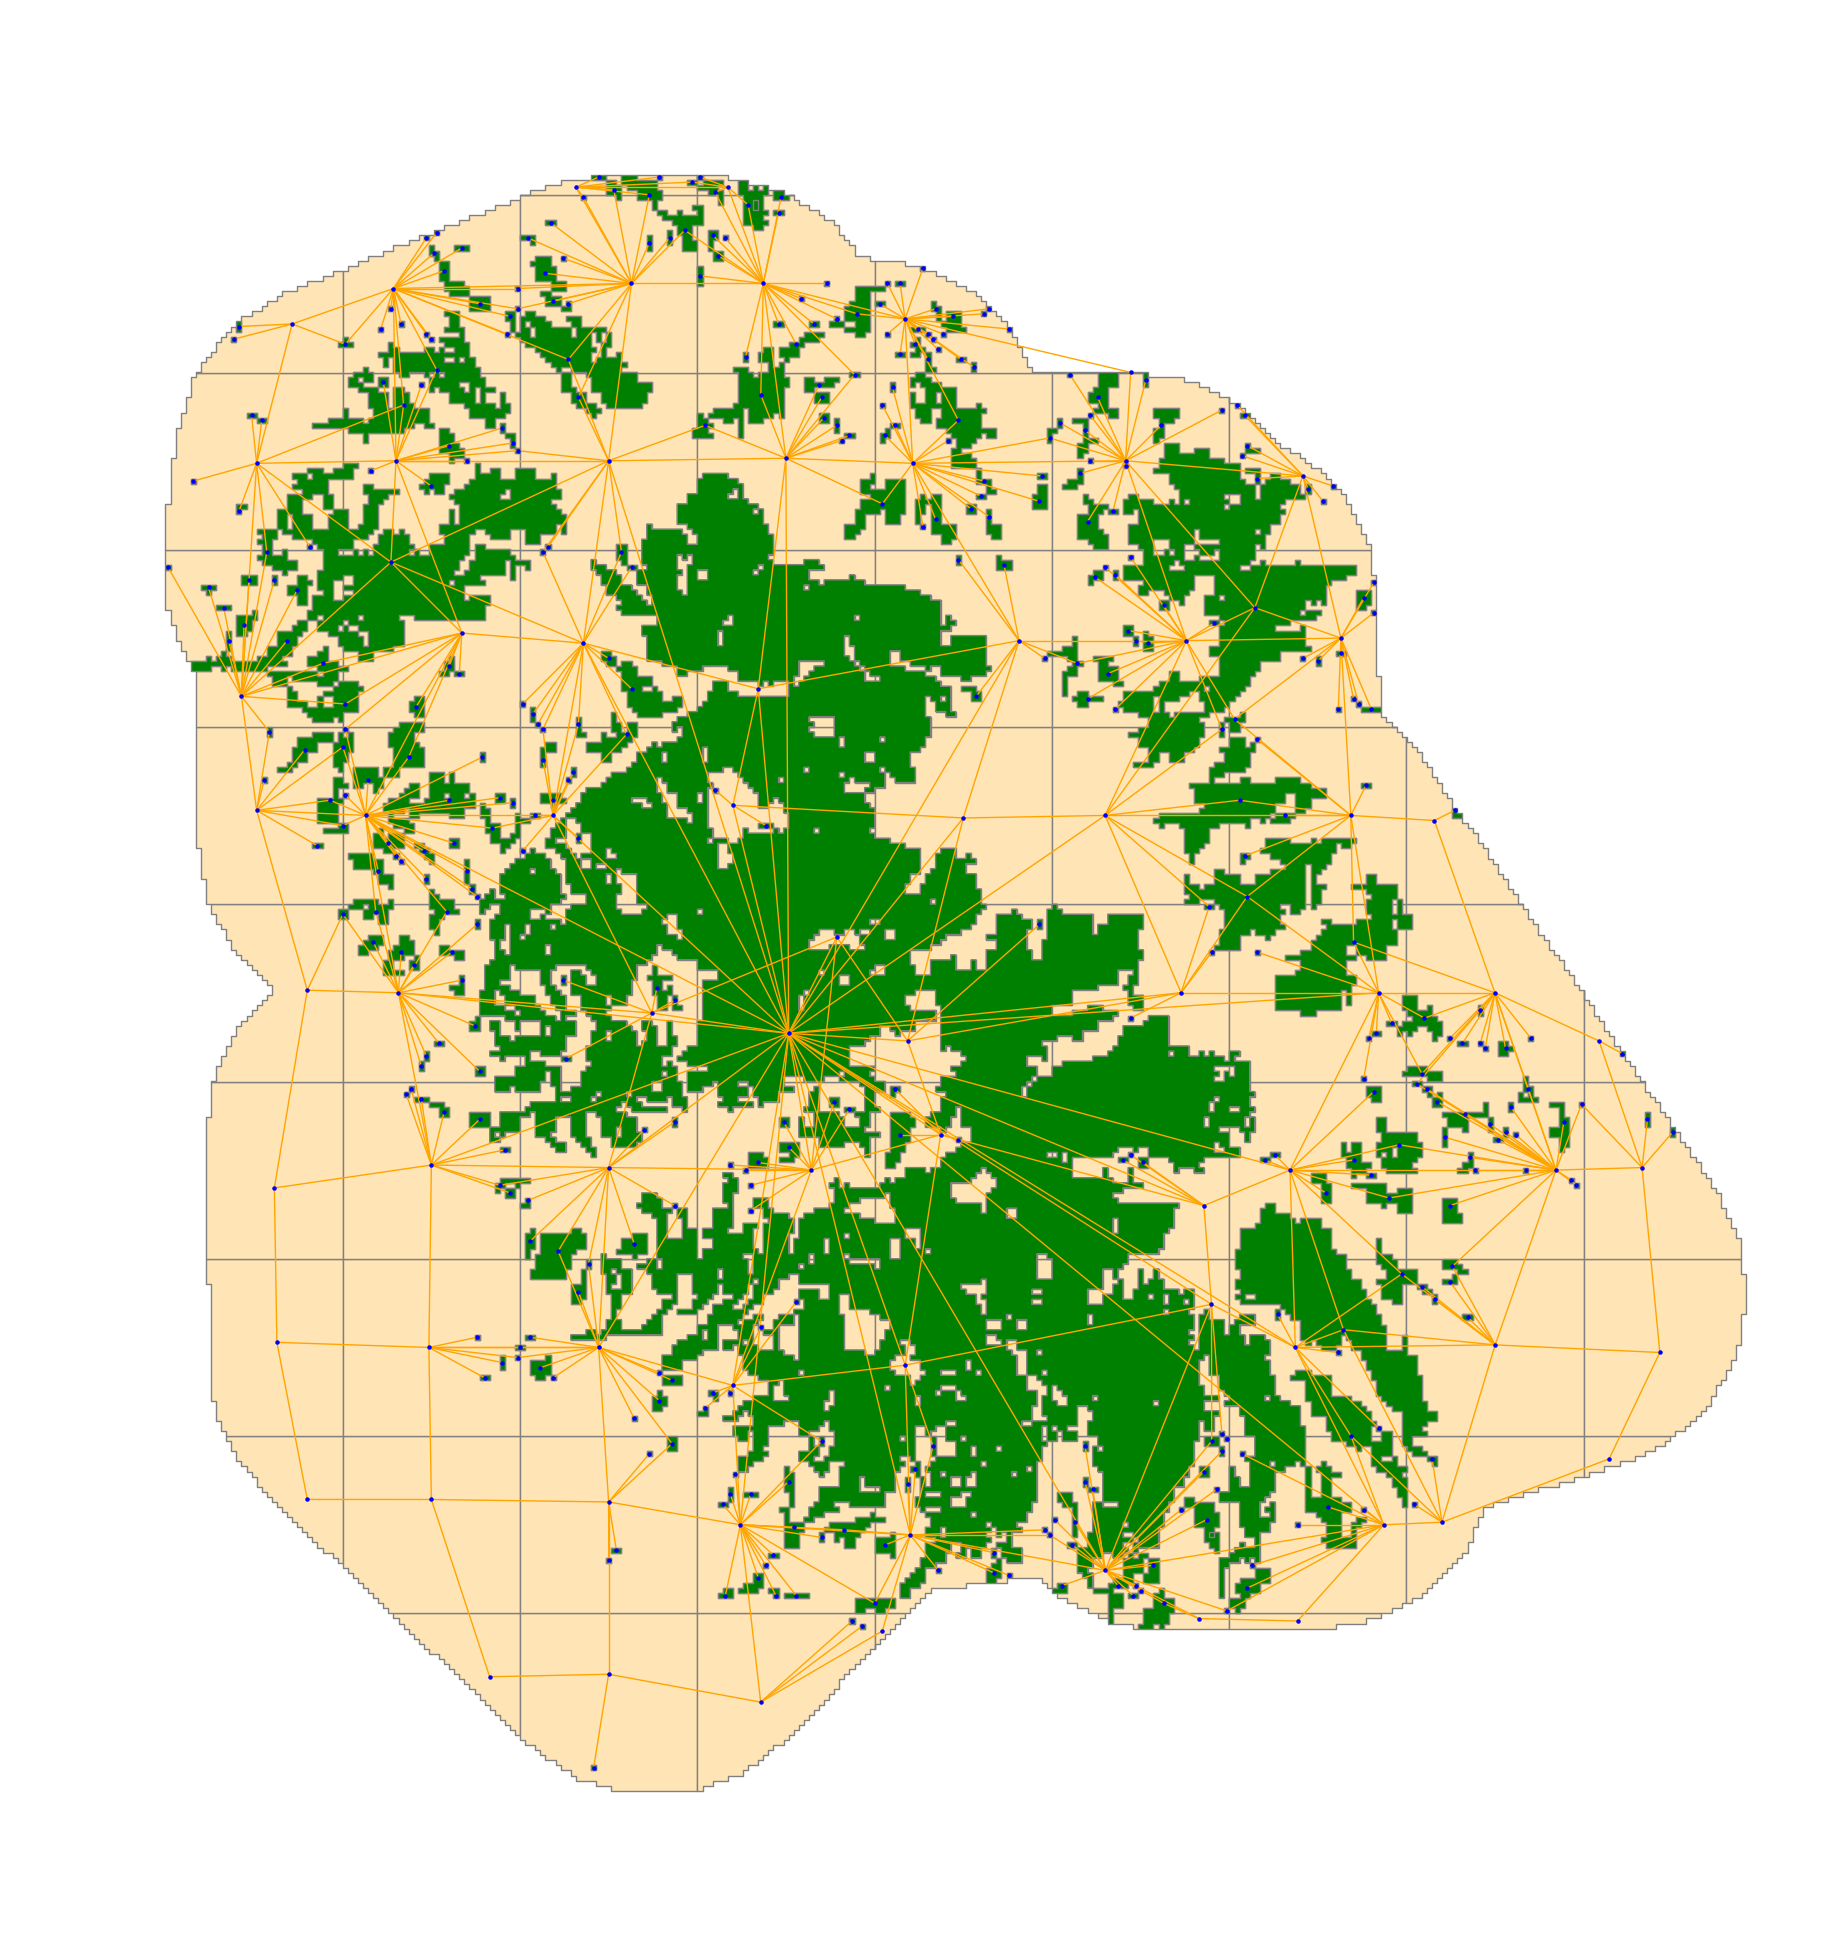

In [47]:
# Concat layers
forest_and_pus = pd.concat([pus, forest_vector])
forest_and_pus["area"] = forest_and_pus.area

# Construct spatial graph
centroids = np.column_stack((forest_and_pus.representative_point().x, forest_and_pus.representative_point().y))
rook = weights.Rook.from_dataframe(forest_and_pus, silence_warnings = True)
graph = rook.to_networkx()

# Plot
fig, ax = plt.subplots(figsize=(25, 25))
forest_and_pus.plot(ax=ax, edgecolor="grey", column="type", cmap=cmap)
positions = dict(zip(graph.nodes, centroids))
nx.draw(graph, positions, node_size=5, node_color="blue", edge_color="orange")
plt.show()

# Model and solve the problem with Pychoco

In [48]:
from pychoco import *

model = Model("reforestation")

forest_nodes = [i for i in graph.nodes if forest_and_pus.iloc[i].type == 1]
all_edges = [(int(i), int(j)) for (i, j) in graph.edges]

#print(forest_nodes)

lb = create_undirected_graph(model, graph.number_of_nodes(), forest_nodes)
ub = create_undirected_graph(model, graph.number_of_nodes(), list(graph.nodes), all_edges)
graph_var = model.node_induced_graphvar(lb, ub, "graph_var")
nb_nodes = model.intvar(0, graph.number_of_nodes(), "nb_nodes")
model.graph_nb_nodes(graph_var, nb_nodes).post()
model.arithm(nb_nodes, "<=", len(forest_nodes) + 2).post()
nb_patches = model.intvar(1, len(forest_nodes))
model.graph_nb_connected_components(graph_var, nb_patches).post()


solver = model.get_solver()
solver.show_short_statistics()

model.set_objective(nb_patches, False)
solver.limit_time("30s")

nodes = []

while solver.solve():
    nodes = graph_var.get_value().get_nodes()

Model[reforestation], 1 Solutions, MINIMIZE IV_1 = 425, Resolution time 0,002s, Time to best solution 0,001s, 4 Nodes (2 564,6 n/s), 1 Backtracks, 0 Backjumps, 1 Fails, 0 Restarts
Model[reforestation], 2 Solutions, MINIMIZE IV_1 = 424, Resolution time 0,003s, Time to best solution 0,003s, 6 Nodes (2 075,5 n/s), 2 Backtracks, 0 Backjumps, 1 Fails, 0 Restarts
Model[reforestation], 3 Solutions, MINIMIZE IV_1 = 422, Resolution time 0,006s, Time to best solution 0,006s, 13 Nodes (2 077,2 n/s), 8 Backtracks, 0 Backjumps, 6 Fails, 0 Restarts
Model[reforestation], 4 Solutions, MINIMIZE IV_1 = 409, Resolution time 0,008s, Time to best solution 0,008s, 15 Nodes (1 764,8 n/s), 9 Backtracks, 0 Backjumps, 6 Fails, 0 Restarts
Model[reforestation], 5 Solutions, MINIMIZE IV_1 = 404, Resolution time 0,011s, Time to best solution 0,011s, 18 Nodes (1 651,9 n/s), 11 Backtracks, 0 Backjumps, 7 Fails, 0 Restarts
Model[reforestation], 6 Solutions, MINIMIZE IV_1 = 401, Resolution time 0,023s, Time to best sol

<AxesSubplot:>

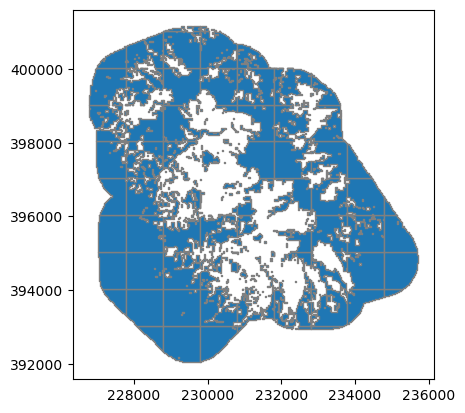

In [49]:
# Get the extent of the shapefile
total_bounds = study_area_vector.total_bounds
# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds
# Create a fishnet
x, y = (minX, minY)
geom_array = []
# Polygon Size
square_size = 1000
while y <= maxY:
    while x <= maxX:
        geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

pus = gpd.GeoDataFrame(geom_array, columns=['geometry'], crs="EPSG:3163")
pus = gpd.overlay(pus, study_area_vector, how='intersection')
pus = gpd.overlay(pus, forest_vector, how='difference')
pus.plot(edgecolor="grey")

<AxesSubplot:>

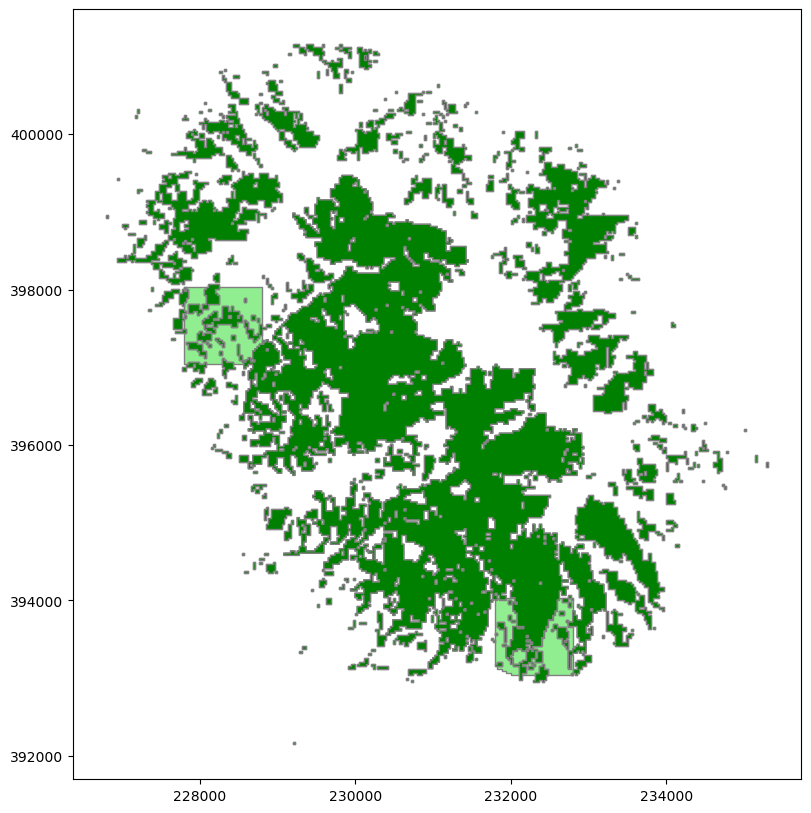

In [50]:
forest_nodes = [i for i in graph.nodes if forest_and_pus.iloc[i].type == 1]
forest_and_pus.iloc[nodes + forest_nodes].plot(edgecolor="grey", column="type", cmap=colors.ListedColormap(["lightgreen", "green"]), figsize=(10, 10))